In [84]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from config.db_configs import *

In [85]:
 import psycopg2

connection = psycopg2.connect(
            dbname=DB_CONFIG["dbname"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"])

In [86]:
query = 'SELECT * FROM properties';
df_og = pd.read_sql(query, con = connection)
urls = df_og[['property_id','url']]
#df_og.drop('url', inplace=True, axis=1)

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_67197/811777537.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_og = pd.read_sql(query, con = connection)


In [87]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4927 entries, 0 to 4926
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   db_id              4927 non-null   int64  
 1   property_id        4927 non-null   int64  
 2   price              4435 non-null   float64
 3   square             4927 non-null   float64
 4   price_per_sqm      4435 non-null   float64
 5   rooms              4927 non-null   int64  
 6   date               4927 non-null   object 
 7   url                4927 non-null   object 
 8   street             3061 non-null   object 
 9   district_1         4927 non-null   object 
 10  district_2         4927 non-null   object 
 11  city               4927 non-null   object 
 12  state              4927 non-null   object 
 13  heating            3690 non-null   object 
 14  floor              4866 non-null   object 
 15  rent               2394 non-null   object 
 16  bld_condition      4331 

,Total,Percent
equipment,3148,63.89
availability,2957,60.02
building_material,2749,55.79
rent,2533,51.41
media,2296,46.60
windows,1951,39.60
street,1866,37.87
security,1525,30.95
heating,1237,25.11
building_year,1146,23.26


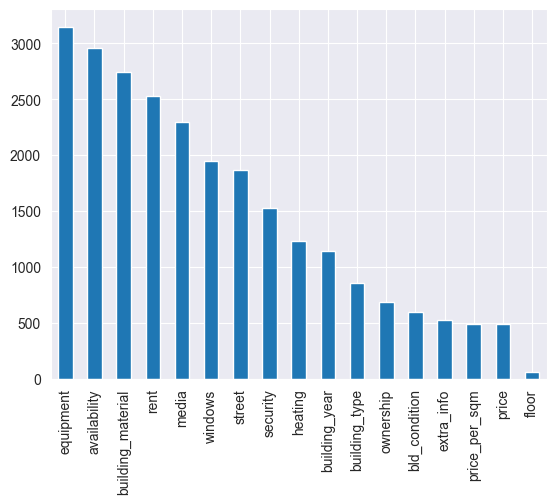

In [88]:
# NaN -> building_type, building_material, windows, media, security, equipment
df_og.replace('NaN', None, inplace=True)
df_og.isna().sum()
def missing_data_bar_plot(df):
    missing_train = df.isnull().sum()
    missing_train = missing_train[missing_train > 0]
    missing_train.sort_values(ascending=False, inplace=True)

    return missing_train.plot.bar()

missing_data_bar_plot(df_og)

def missing_values(df):
    missing_values = df.isnull().sum()
    percent = round((missing_values/len(df)) * 100, 2)
    
    missing_data = pd.concat([missing_values, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total'] > 0]
    return missing_data.sort_values('Percent', ascending=False) 
missing_values(df_og)

We have apparent deficiencies in a lot of data columns, such as: 

- target variable **price** has 10% of missing values, which means we have to drop these rows from our model and **price_per_sqm** is based on target variable so it means that we have to drop it nighter but we will do this in the later stage, for now it is interesting for me.

- **equipment**, **availability**, **builiding_material** and **rent** has **>50%** missing values so consider removing them, however **rent** feature could possibly be useful for our model so we will keep it for now. 

- **media**, **windows**, **street**, **security** has **>30%** of missing values and they are probably not crucial for model so we will remove them.

- **heating**, **building_year**, **building_type**, **ownership** , **bld_condition** can be useful insights for our model but their missing values percantage is in range 12-25% so we have to deal with it later. 
- **extra_info** has 10% of missing values but the values. The data is highly variable, and its usefulness is probably not very high so we will remove it.

- **floor** feature has low percentage of missing values we will keep it. 

In [89]:
df = df_og[df_og['price'].notna()].copy()
df = df.drop(
    columns=['equipment', 'availability', 'building_material', 'media', 'windows', 'street', 'security', 'extra_info']
)

In [90]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
db_id,4435.0,2738.77,1654.04,2.0,1299.50,2672.00,4072.5,5812.0
property_id,4435.0,66212546.84,713291.07,43983758.0,66139751.00,66457992.00,66548525.0,66611144.0
price,4435.0,677327.38,347041.21,28000.0,484339.85,598200.00,748347.0,5100000.0
square,4435.0,56.47,26.81,12.5,41.91,51.18,65.3,817.0
price_per_sqm,4435.0,12175.61,3193.31,1903.0,10248.50,11632.00,13500.0,97188.0
rooms,4435.0,2.57,0.97,1.0,2.00,2.00,3.0,10.0
building_year,3319.0,2000.26,58.79,70.0,1984.00,2023.00,2025.0,2027.0


In [91]:
df.replace('NaN', None, inplace=True)
df.isna().sum()

db_id               0
property_id         0
price               0
square              0
price_per_sqm       0
rooms               0
date                0
url                 0
district_1          0
district_2          0
city                0
state               0
heating           859
floor              61
rent             2044
bld_condition     591
market              0
ownership         680
seller_type         0
building_year    1116
elevator            0
building_type     573
dtype: int64

In [92]:
import re
df['rent'] = df['rent'].apply(
    lambda x: (lambda r: float(r.replace(',', '.')) if r else None)(re.sub(r'[^\d,\.]', '', x))
    if isinstance(x, str) else x)

In [93]:
df['floor'].value_counts()

floor
4/4           339
3/4           283
1/4           240
parter/4      236
2/4           225
             ... 
> 10/18         1
10/13           1
4/15            1
poddasze/6      1
3/14            1
Name: count, Length: 163, dtype: int64

In [94]:
def convert_floors(df):
    def parse(s):
        s = str(s).strip().lstrip('>').strip()
        if '/' in s:
            left, right = s.split('/', 1)
            left = left.lower().strip()
            prp = 0 if left == 'parter' else (-1 if left == 'suterena' else int(left) if left.isdigit() else None)
            bld = int(right.strip()) if right.strip().isdigit() else None
        else:
            s_low = s.lower()
            if s_low == 'parter':
                prp, bld = 0, None
            elif s_low == 'suterena':
                prp, bld = -1, None
            else:
                prp, bld = int(s) if s.isdigit() else None, None
        return prp, bld

    #  process each value in the 'floor' column and build new ones
    parsed = df['floor'].apply(parse)
    df['property_floor'] = parsed.apply(lambda x: x[0])
    df['num_floors'] = parsed.apply(lambda x: x[1])
    
    return df

convert_floors(df)
df.drop(columns=['floor'], inplace=True)
df['floor_ratio'] = round((df['property_floor'] / df['num_floors']),3)

In [95]:
df[['property_floor', 'num_floors']]

,property_floor,num_floors
0,0.0,6.0
1,5.0,5.0
2,2.0,4.0
3,3.0,5.0
4,0.0,6.0
...,...,...
4921,1.0,4.0
4922,4.0,4.0
4923,1.0,4.0
4924,2.0,5.0


In [96]:
df['floor_ratio']

0       0.00
1       1.00
2       0.50
3       0.60
4       0.00
        ... 
4921    0.25
4922    1.00
4923    0.25
4924    0.40
4926    0.25
Name: floor_ratio, Length: 4435, dtype: float64

In [97]:
df.dtypes

db_id               int64
property_id         int64
price             float64
square            float64
price_per_sqm     float64
rooms               int64
date               object
url                object
district_1         object
district_2         object
city               object
state              object
heating            object
rent              float64
bld_condition      object
market             object
ownership          object
seller_type        object
building_year     float64
elevator           object
building_type      object
property_floor    float64
num_floors        float64
floor_ratio       float64
dtype: object

In [98]:
# building_year, property_floor, num_floors and rooms should be an categorical variable 
cols_to_convert = ['building_year', 'rooms', 'property_floor', 'num_floors']
df[cols_to_convert] = df[cols_to_convert].astype('object')

Features **city** and **state** has the same data in each row 'Poznan' and 'wielkopolskie' so they won't contribute anything to the model therefore they can be removed.

We don't need feature **district_2** because we got **district_1** which indicates a more precise district

We won't need the **db_id** feature either, while we'll leave the **property_id** for now, for ease of data navigation 

In [99]:
df.drop(
    columns=['city', 'state', 'district_2', 'db_id'],
    inplace=True
)

In [100]:
num_features = df.select_dtypes(include=['number']).drop(columns=['property_id'], errors='ignore').columns
cat_features = df.select_dtypes(include=['object']).columns
print(num_features)
print(cat_features)

Index(['price', 'square', 'price_per_sqm', 'rent', 'floor_ratio'], dtype='object')
Index(['rooms', 'date', 'url', 'district_1', 'heating', 'bld_condition',
       'market', 'ownership', 'seller_type', 'building_year', 'elevator',
       'building_type', 'property_floor', 'num_floors'],
      dtype='object')


# EDA


In [101]:
def numerical_data_viz(df): 
    '''
    The function generates visualizations for all numeric columns in the passed DataFrame.
    
    :param df: DataFrame containing the data for which the graphs are to be generated.
    :return: The function does not return a value, but displays a set of graphs for each numeric column.
    
    For each numerical column, the following are generated:
    - In the first column: a box plot
    - In the second column: a histogram
    - In the third column: a density plot 
    '''
    num_features = df.select_dtypes(include=['number']).columns 

    # setting the size of plot
    n_cols, n_rows = 3, len(num_features)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # iteration through columns
    for i, col in enumerate(num_features):
        sns.boxplot(df[col], ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{col} - Boxplot')
        
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i, 1], color='lightgreen')
        axes[i, 1].set_title(f'{col} - Histogram')
        
        sns.kdeplot(df[col], ax=axes[i, 2], color='coral')
        axes[i, 2].set_title(f'{col} - Denisity')
        
    for ax in axes.flat:
        ax.set_ylabel('') 
        ax.set_xlabel('')
        
    plt.tight_layout()
    plt.show()
    
    
    
def scatter_viz(data, numeric_features, target_feature):
    """
    Creates scatter plots for all numeric features in the data against the target variable.
    Parameters:
        data (DataFrame): Input data containing the numeric features and the target variable.
        target_feature (str): The column name of the target variable.
    """
    n_cols = 3 
    n_rows = math.ceil(len(numeric_features) / n_cols)  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(numeric_features):
        sns.scatterplot(x=col, y=target_feature, hue=target_feature, data=data, ax=axes[i], palette='Blues')

        axes[i].set_xlabel(col, size=15, labelpad=12)
        axes[i].set_ylabel(target_feature, size=15, labelpad=12)
        axes[i].legend(loc='best', prop={'size': 10})

    # Hide empty axes, if any
    for j in range(len(numeric_features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()




def reg_viz(data, numeric_features, target_feature):
    """
    Creates scatter plots for all numeric features in the data against the target variable,
    With a trend line added.

    Parameters:
        data (DataFrame): Input data containing the numerical features and the target variable.
        target_feature (str): The column name of the target variable.
    """
    n_cols = 3
    n_rows = math.ceil(len(numeric_features) / n_cols) 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(numeric_features):
        sns.regplot(x=col, y=target_feature, data=data, ax=axes[i], line_kws={'color': 'red', 'linewidth': 2})
        
        axes[i].set_xlabel(col, size=15, labelpad=12)
        axes[i].set_ylabel(target_feature, size=15, labelpad=12)

    # Hide empty axes, if any
    for j in range(len(numeric_features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [102]:
def categorical_data_viz(df, categorical_features, target_feature): 
    '''
    Visualizes categorical features with:
    1. Boxplots to show the target feature's distribution across categories.
    2. Countplots to display category frequencies.

    Parameters:
    - df: DataFrame with the data.
    - categorical_features (list): List of categorical feature names.
    - target_feature (str): Target feature name.

    '''
    #num_features = df.select_dtypes(include=['number']).columns 

    # setting the size of plot
    n_cols, n_rows = 2, math.ceil(len(categorical_features))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    
    # iteration through columns
    for i, col in enumerate(categorical_features):
         # Boxplot
        sns.boxplot(x=col, y=target_feature, data=df, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{col} - Boxplot', fontsize=12)
        
         # Countplot
        sns.countplot(x=col, data=df, ax=axes[i, 1], palette='Set2')
        axes[i, 1].set_title(f'{col} - Countplot', fontsize=12)
        
        
    for ax in axes.flat:
        ax.set_ylabel('') 
        ax.set_xlabel('')
        
    plt.tight_layout()
    plt.show()

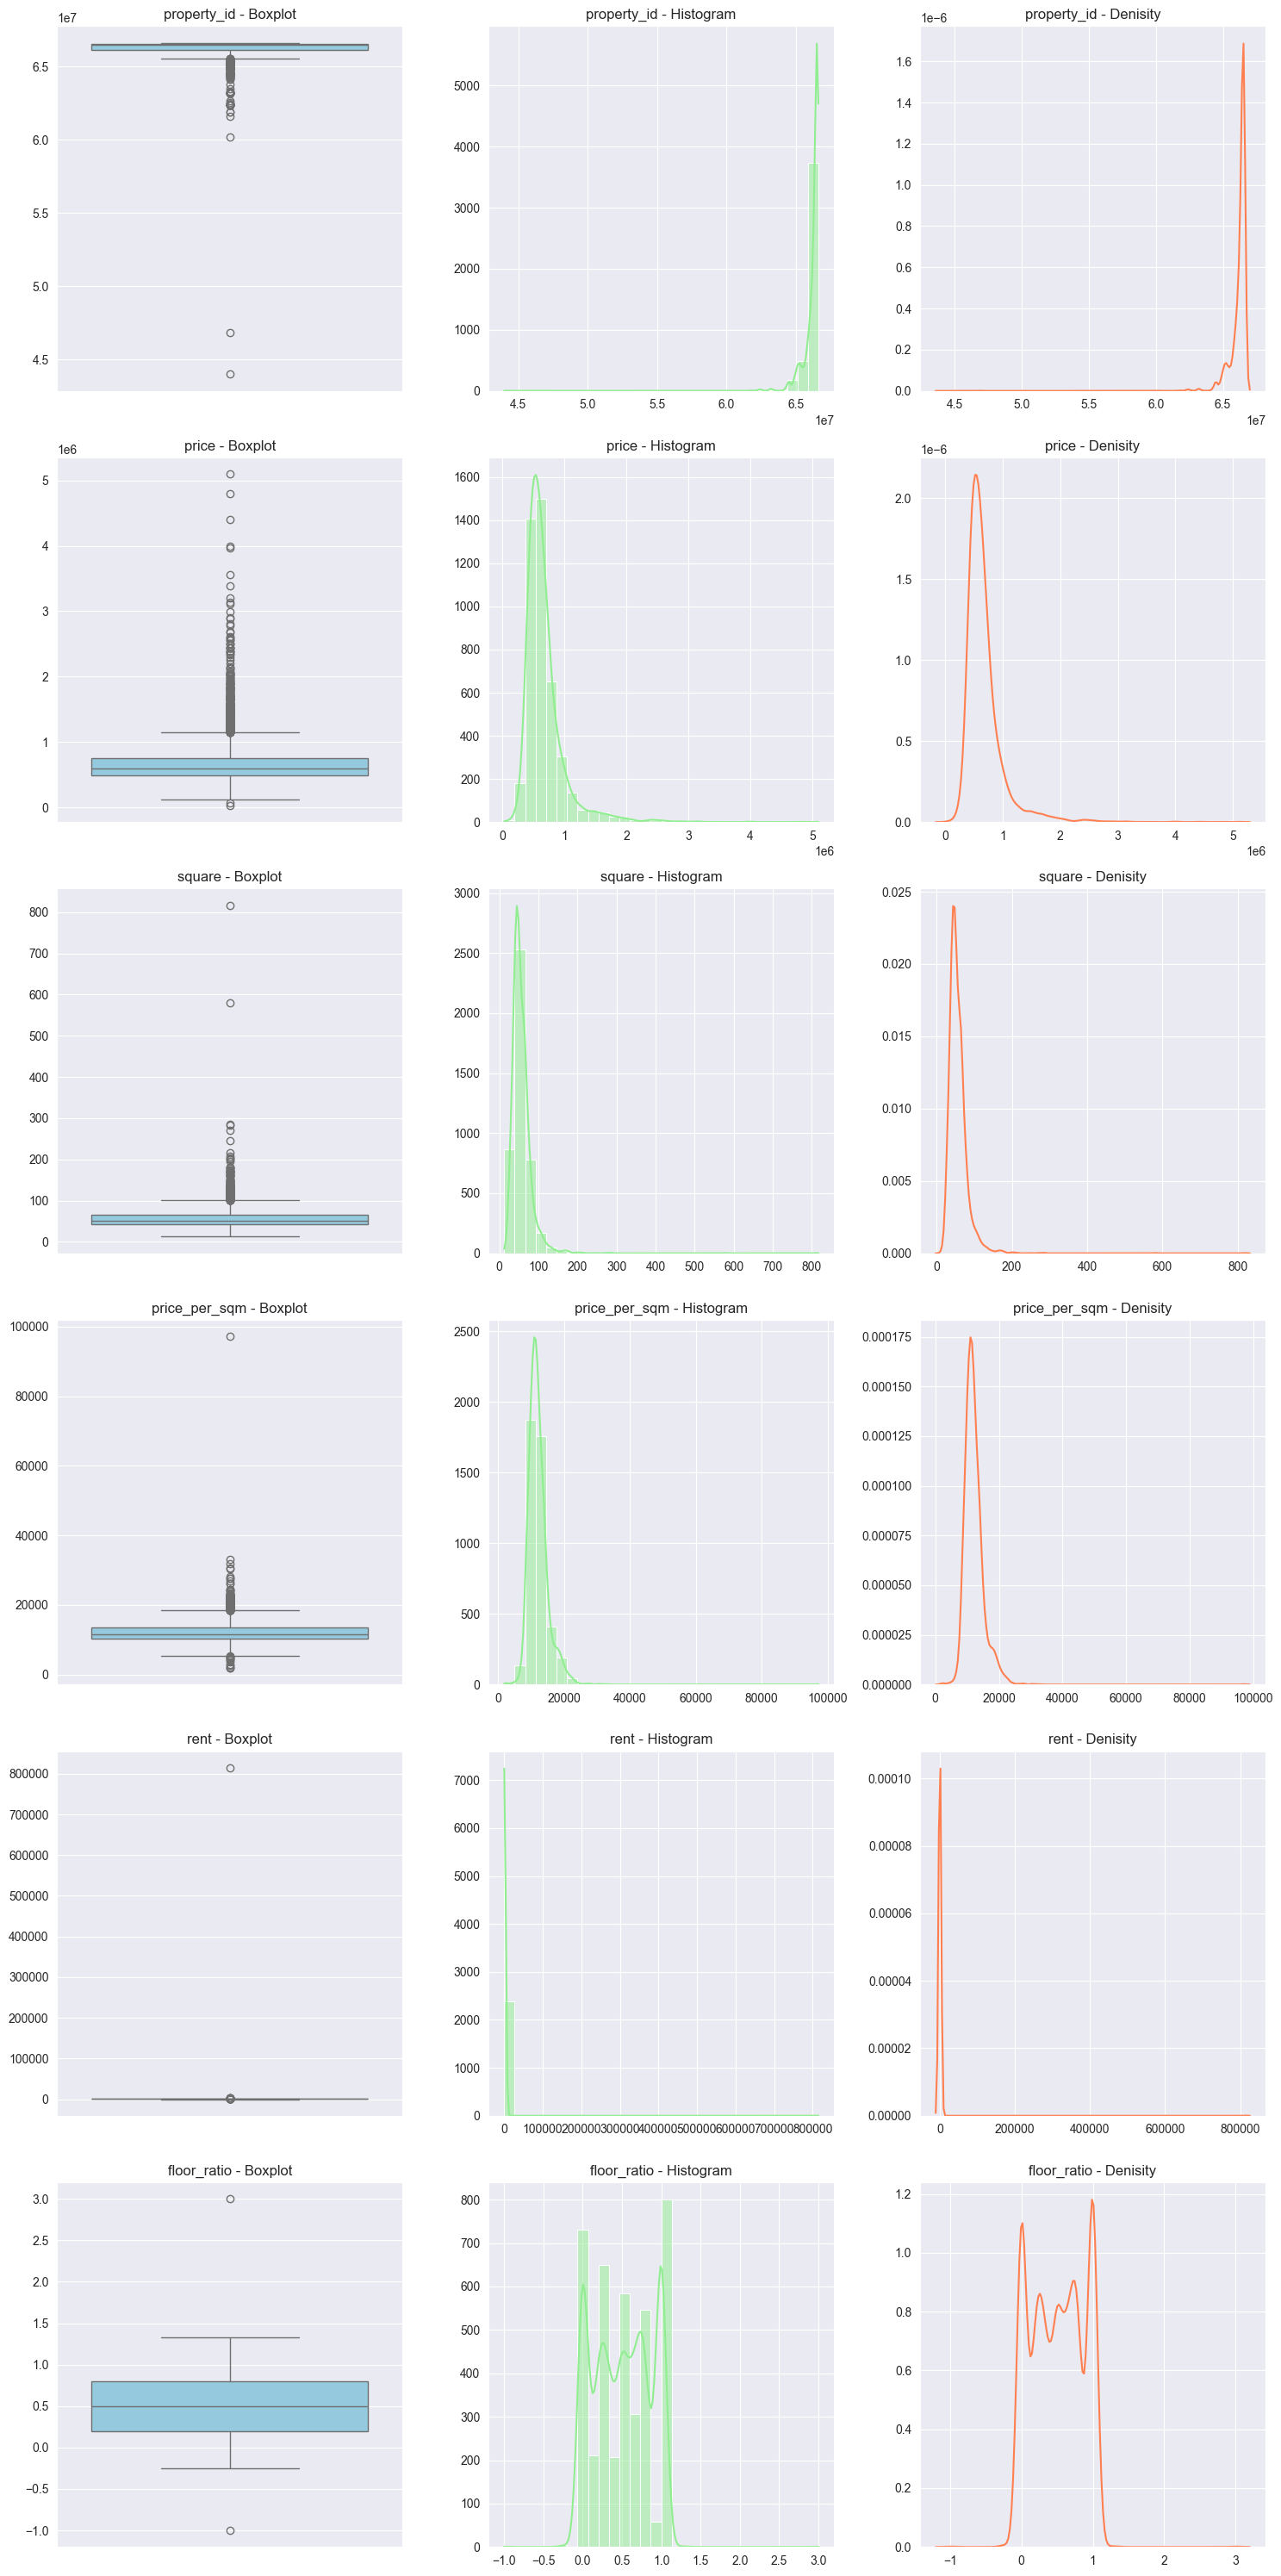

In [103]:
numerical_data_viz(df)

In [104]:
#categorical_data_viz(df, cat_features, 'price')

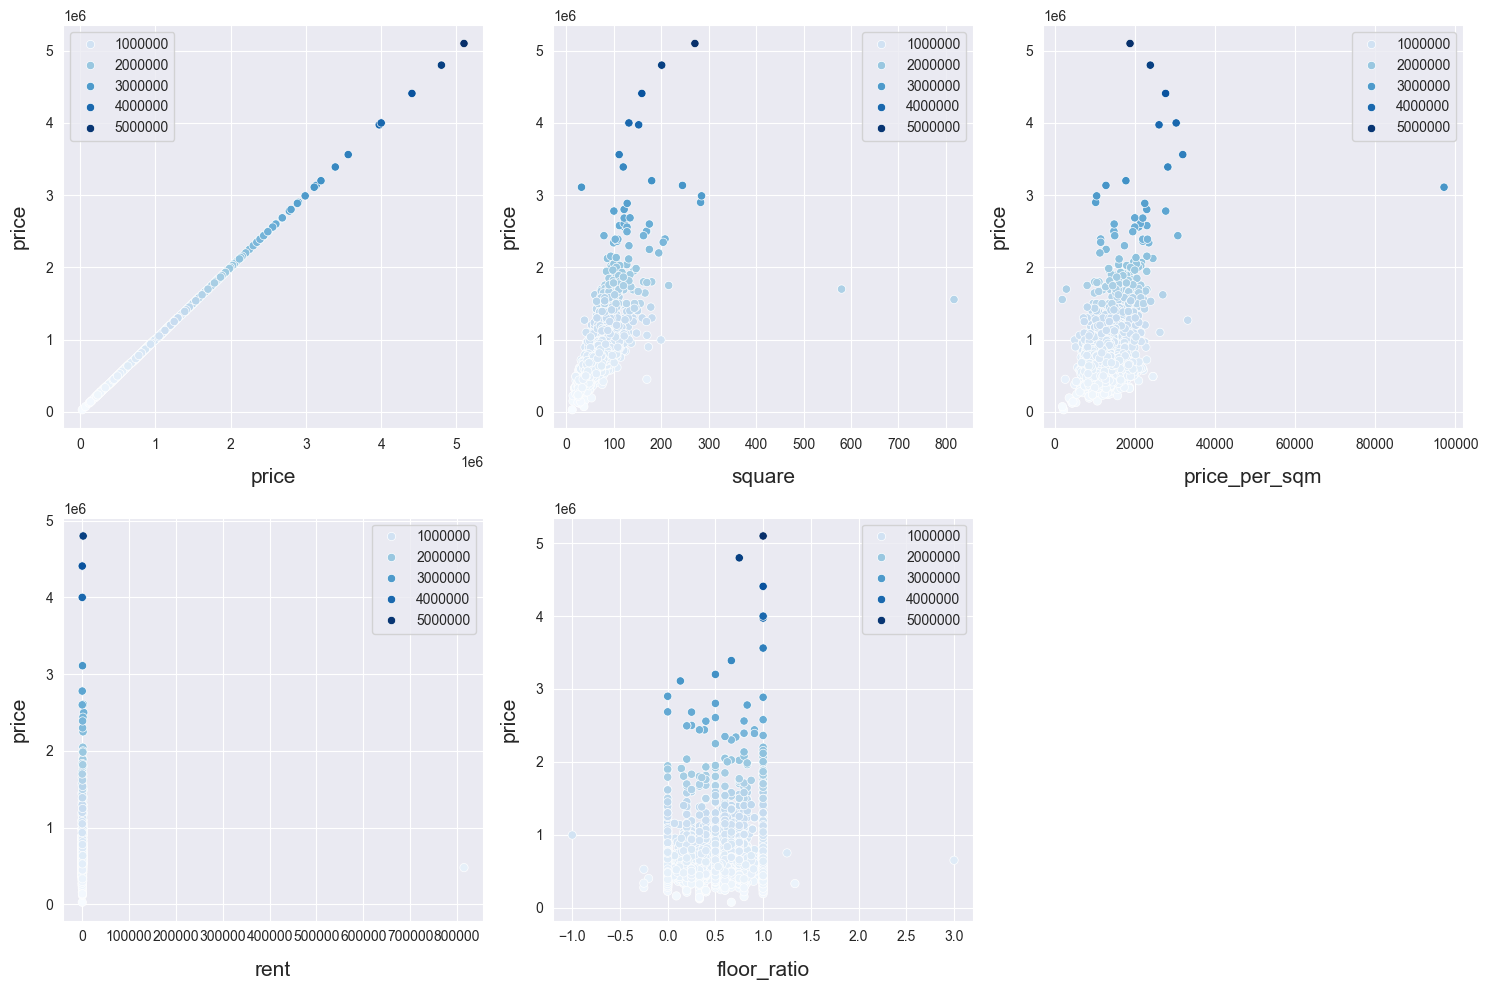

In [105]:
scatter_viz(df, num_features, 'price')

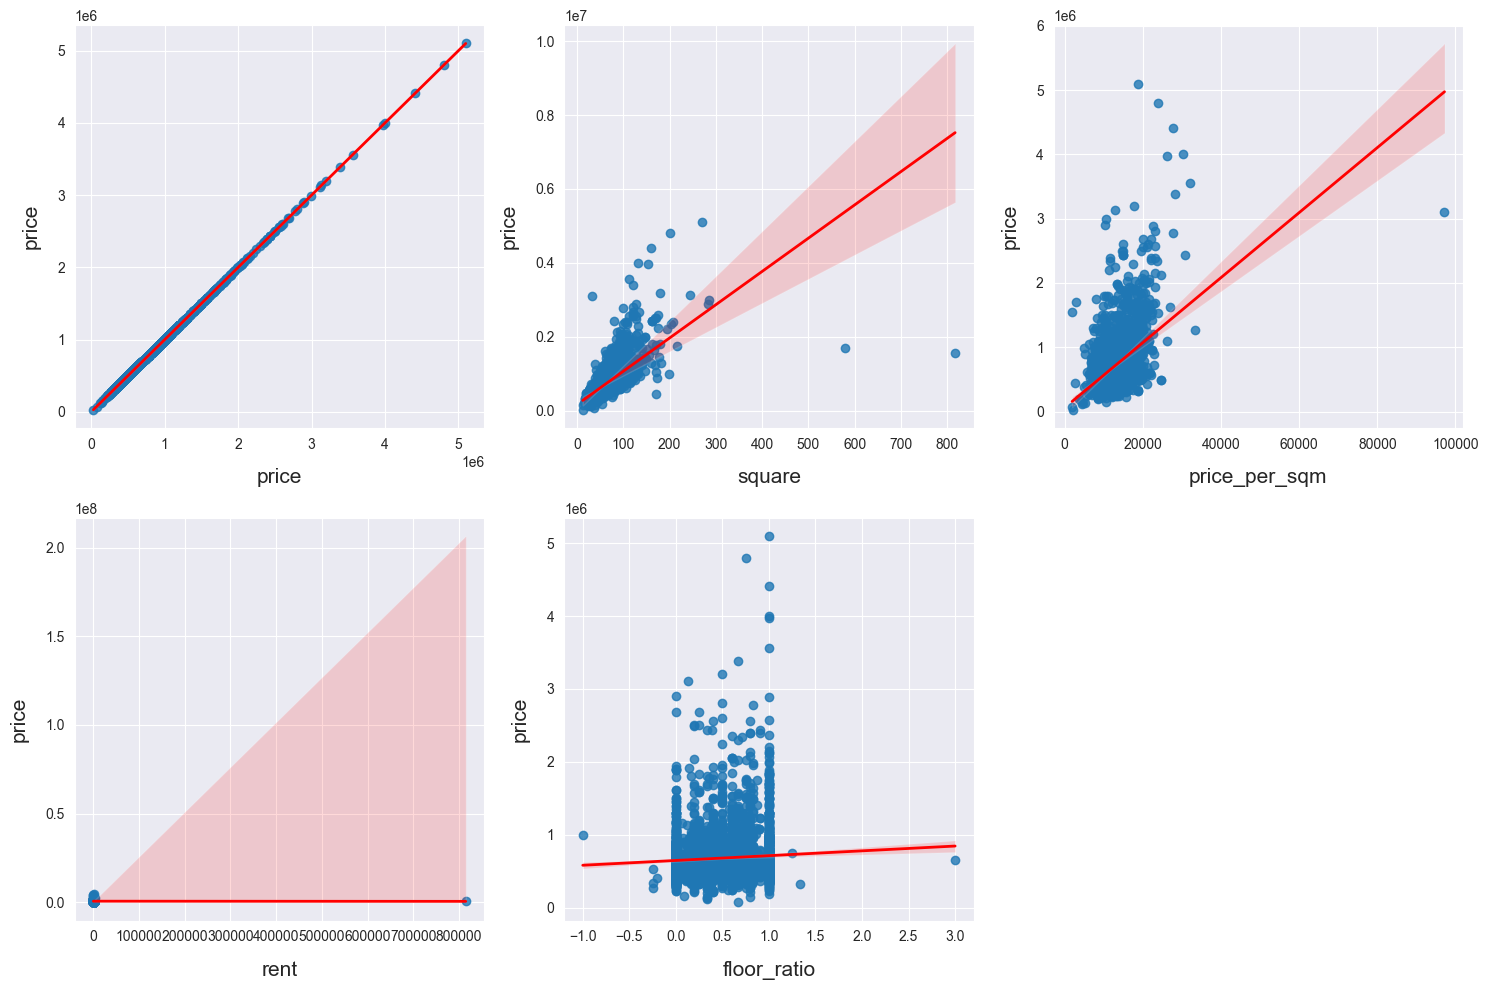

In [106]:
reg_viz(df, num_features, 'price')

## Deal with data having errors
Some data points looks like anomaly so probably has errors occurred by users or by scraping algorithms

In [107]:
df[df['rent'] > 10000] # this rent price was way too high so I decided to change it to None value
df.loc[3770, 'rent'] = None
df.query("property_id == 66384406")

,property_id,price,square,price_per_sqm,rooms,date,url,district_1,heating,rent,bld_condition,market,ownership,seller_type,building_year,elevator,building_type,property_floor,num_floors,floor_ratio
3770,66384406,480000.0,47.8,10042.0,3,2025-03-18,https://www.otodom.pl/pl/oferta/trzypokojowe-n...,Rataje,miejskie,NaN,do zamieszkania,wtórny,spółdzielcze wł. prawo do lokalu,biuro nieruchomości,NaN,nie,blok,1.0,4.0,0.25


In [108]:
df[df['price_per_sqm'] > 35000] # we got mistake in price of this property, unfortunately it's changed and by the URL link we can't see this offer, so I will delete this property
df.drop(df[df['price_per_sqm'] > 35000].index, inplace=True)

In [109]:
df[df['building_year'] < 1800] 
# year == 70 means probably that's apartment from 70s, but I can't confirm that so I will give a None value
# year == 1664 is also a mistake based on inquiry so it will get None as well
# year == 202 is mistake it will get None
df.loc[df['building_year'] < 1800, 'building_year'] = None

In [110]:
# Model should work well for apartments, so apartments bigger than 300 sqm are anomaly worth to check 
df[df['square'] > 300] # these listings are houses converted into apartments or commercial premises, I am not able to separate this well into several listings
df.drop(df[df['square'] > 300].index, inplace=True)

In [111]:
# We deal with apartments that has some errors with num_floors, eg. The apartment is on floor 3, and the building has a total of 1 floor
df.loc[[3859,3958,4067], ['num_floors', 'floor_ratio']] = None
df.loc[191, 'floor_ratio'] = None
df.query("property_id == 66435355")

,property_id,price,square,price_per_sqm,rooms,date,url,district_1,heating,rent,bld_condition,market,ownership,seller_type,building_year,elevator,building_type,property_floor,num_floors,floor_ratio
3859,66435355,648875.0,44.75,14500.0,2,2025-03-18,https://www.otodom.pl/pl/oferta/jezyce-nowe-mi...,Ogrody,miejskie,650.0,do wykończenia,wtórny,pełna własność,biuro nieruchomości,2024.0,nie,blok,3.0,None,NaN


In [112]:
df['building_type'].value_counts()

building_type
blok                2578
kamienica            686
apartamentowiec      523
dom wolnostojący      35
szeregowiec           26
plomba                11
Name: count, dtype: int64

In [113]:
df['heating'].value_counts()

heating
miejskie         2739
gazowe            424
inne              305
kotłownia          62
elektryczne        37
piece kaflowe       6
Name: count, dtype: int64

In [114]:
df['bld_condition'].value_counts()

bld_condition
do zamieszkania    1788
do wykończenia     1777
do remontu          276
Name: count, dtype: int64

In [115]:
df['building_type'].value_counts()

building_type
blok                2578
kamienica            686
apartamentowiec      523
dom wolnostojący      35
szeregowiec           26
plomba                11
Name: count, dtype: int64

In [116]:
df_grouped = df.groupby('district_1').agg(
                    num_properties = ('property_id', 'count'),
                    avg_price = ('price', 'mean'),
                    avg_square = ('square', 'mean'),
                    avg_price_per_sqm = ('price_per_sqm', 'mean'),
                    avg_rent = ('rent', 'mean'),
                    avg_floor_ratio = ('floor_ratio', 'mean')
                ).reset_index()
df_filtered = df_grouped.query("num_properties > 20").round(2)
df_filtered

,district_1,num_properties,avg_price,avg_square,avg_price_per_sqm,avg_rent,avg_floor_ratio
2,Centrum,235,881994.49,58.25,15114.99,405.12,0.53
3,Chartowo,47,590290.43,58.33,10263.40,691.97,0.53
9,Dębiec,43,525062.79,48.16,11142.44,597.09,0.60
14,Grunwald,205,704802.60,60.18,11877.58,553.85,0.48
15,Górczyn,49,644167.35,56.90,11739.49,546.59,0.48
18,Główna,66,427433.47,40.05,10650.50,454.93,0.57
19,Jeżyce,560,723266.88,57.80,12925.67,470.72,0.45
20,Junikowo,203,688798.61,58.38,11923.03,501.97,0.50
21,Kasztelanów,88,766103.37,56.48,13710.66,437.79,0.47
23,Komandoria,30,628366.63,47.68,13666.67,428.62,0.39


To avoid inflating single listings, I decided to check only those neighborhoods that have >20 real estate sales listings. 

1. **Prices** are highest in the center and around Sołacz, and lowest on the outskirts (Luboń, Plewiska).
2. **Price per sqm** varies widely by district - a key metric for investors.
3. **Rents** do not always go hand in hand with price - expensive Sołacz, for example, has a relatively high rent, but Łazarz, for example, no longer.

/var/folders/09/hzqlxwvx48xgnpqbw795j5tm0000gn/T/ipykernel_67197/2970293062.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


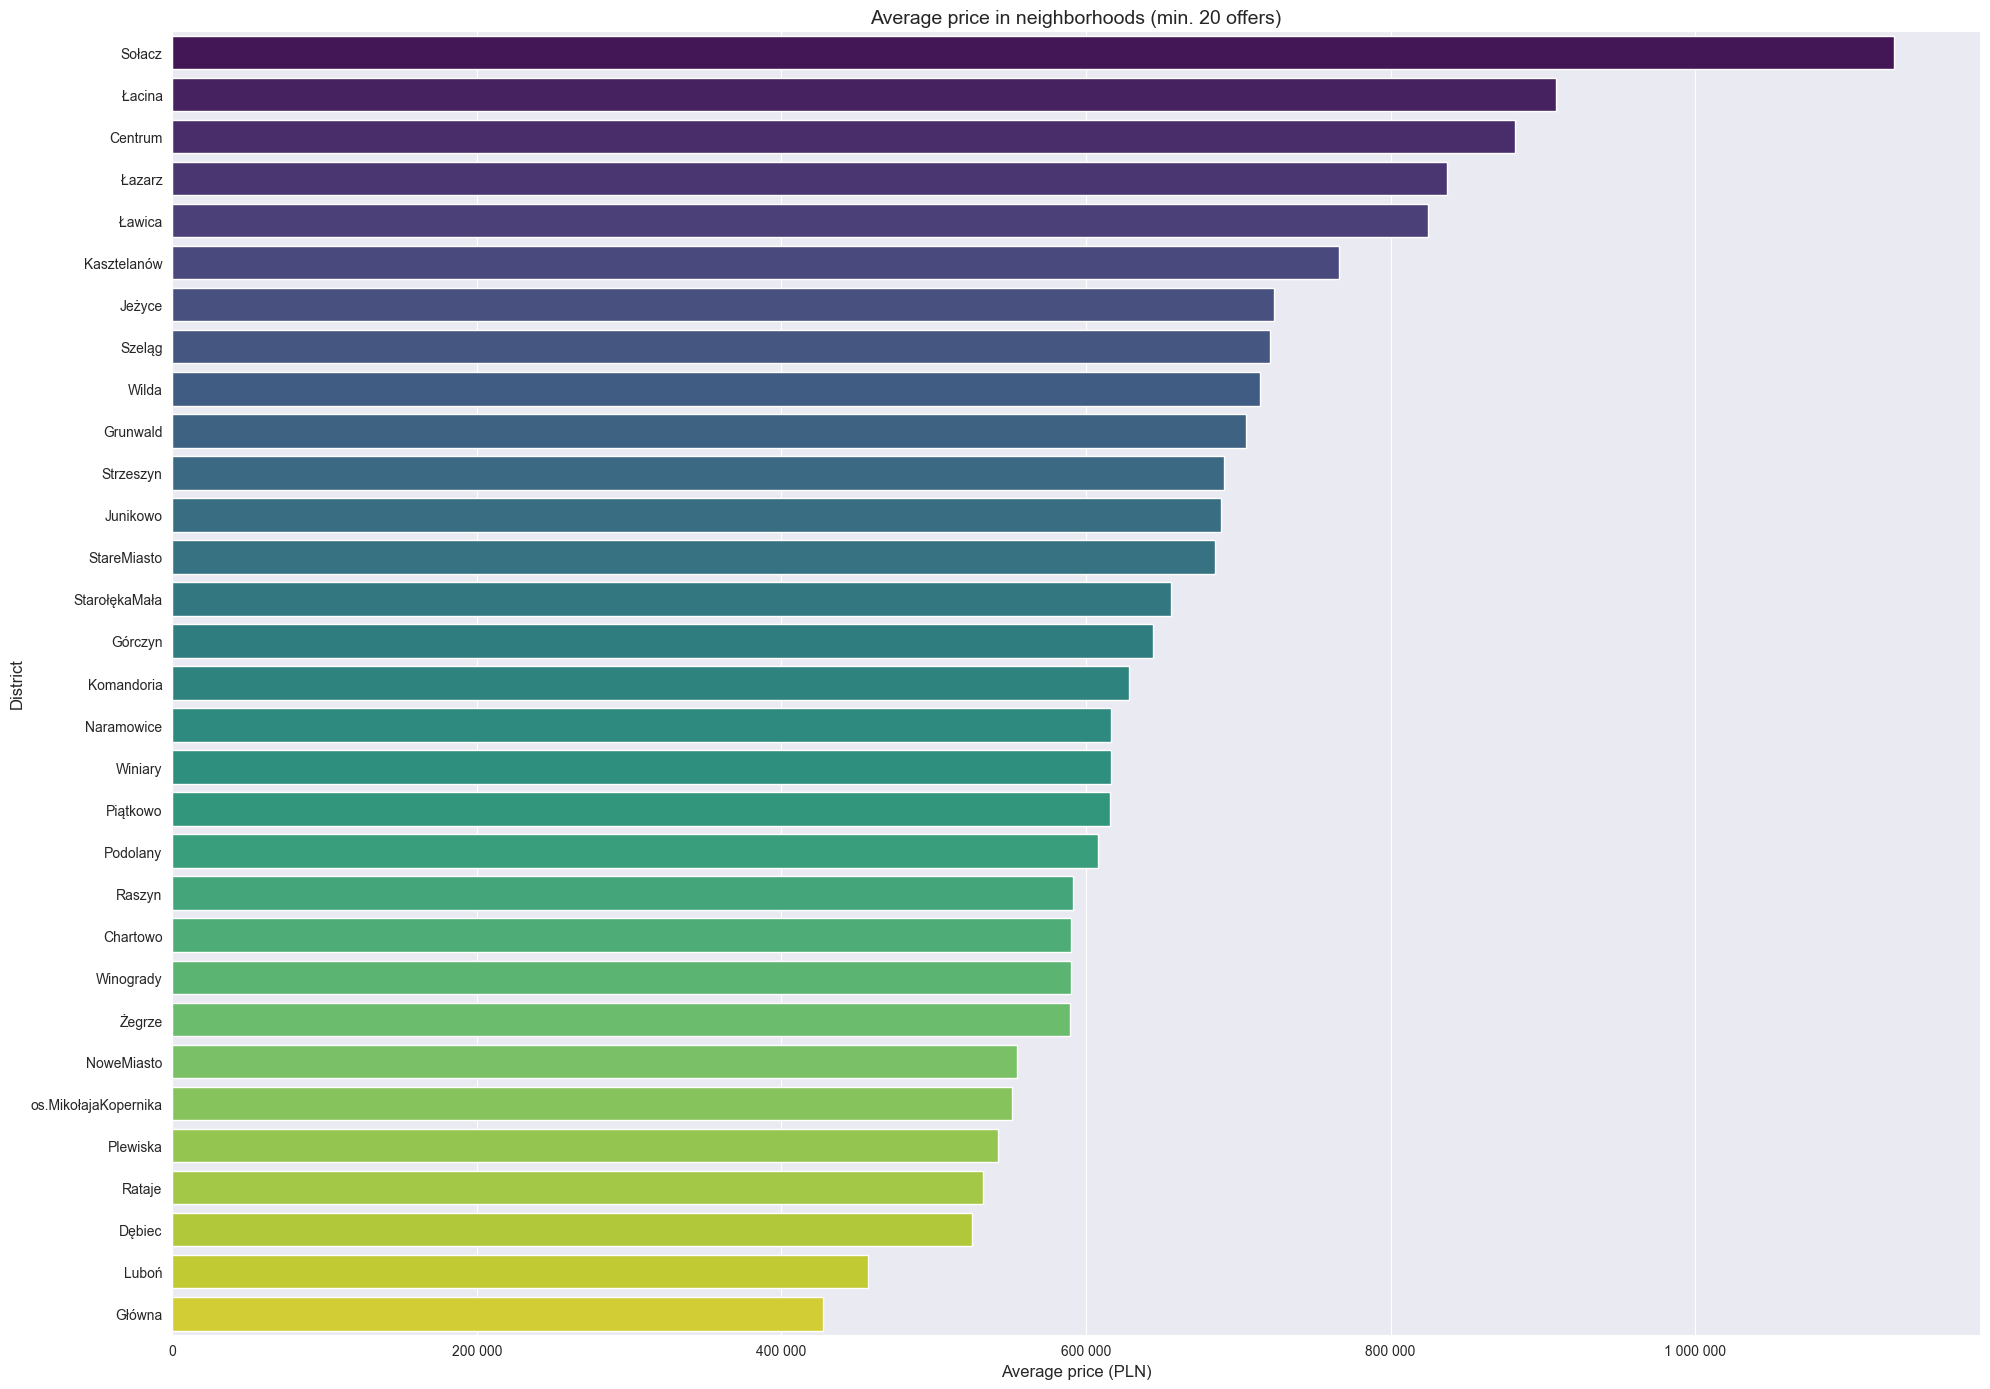

In [117]:
from matplotlib.ticker import FuncFormatter

df_sorted_avg_price = df_filtered.sort_values(by='avg_price', ascending=False)

plt.figure(figsize=(20,14))
sns.barplot(
    data=df_sorted_avg_price,
    x='avg_price',
    y='district_1',
    palette='viridis'
)
plt.title('Average price in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

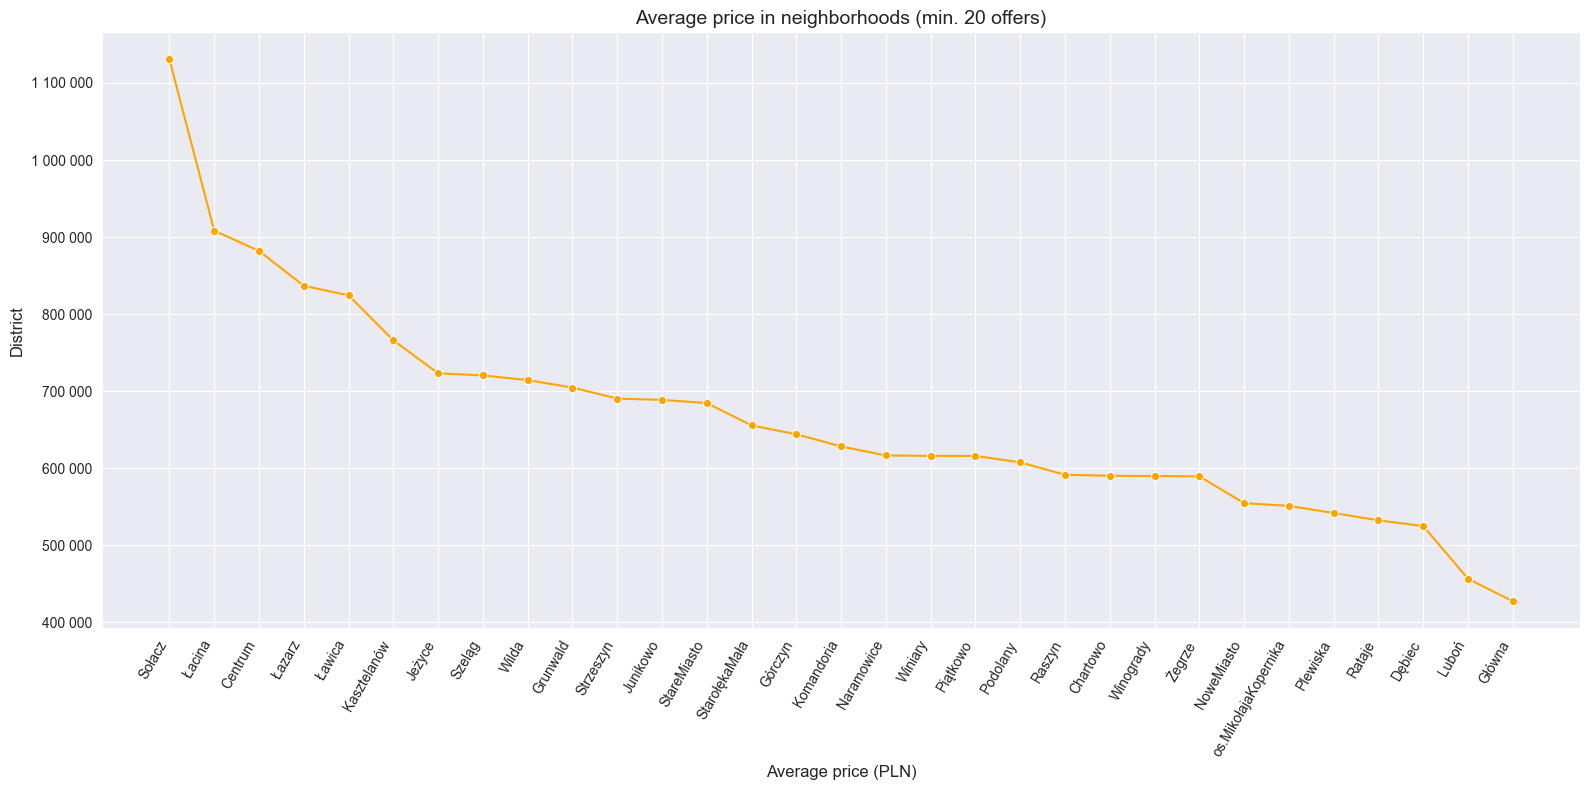

In [118]:
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df_sorted_avg_price,
    x='district_1',
    y='avg_price',
    marker='o',
    color='orange',
)

plt.xticks(rotation=60, ha='right')

plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average price in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)

plt.tight_layout()
plt.show()

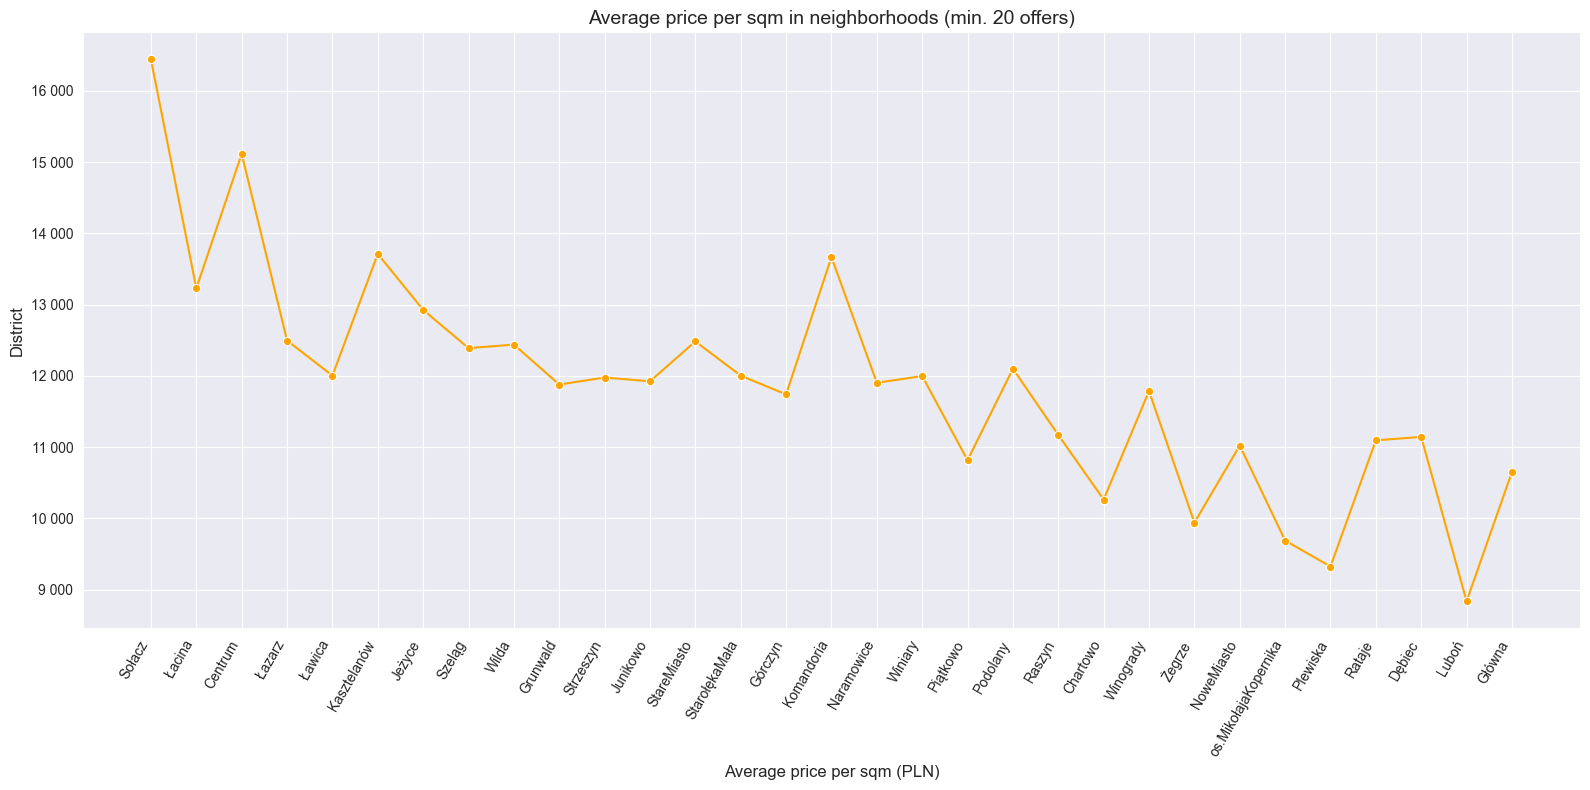

In [119]:
df_sorted_avg_price_per_sqm = df_filtered.sort_values(by='avg_price_per_sqm', ascending=False)
plt.show()
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=df_sorted_avg_price,
    x='district_1',
    y='avg_price_per_sqm',
    marker='o',
    color='orange',
)

plt.xticks(rotation=60, ha='right')

plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average price per sqm in neighborhoods (min. 20 offers)', fontsize=14)
plt.xlabel('Average price per sqm (PLN)', fontsize=12)
plt.ylabel('District', fontsize=12)

plt.tight_layout()
plt.show()

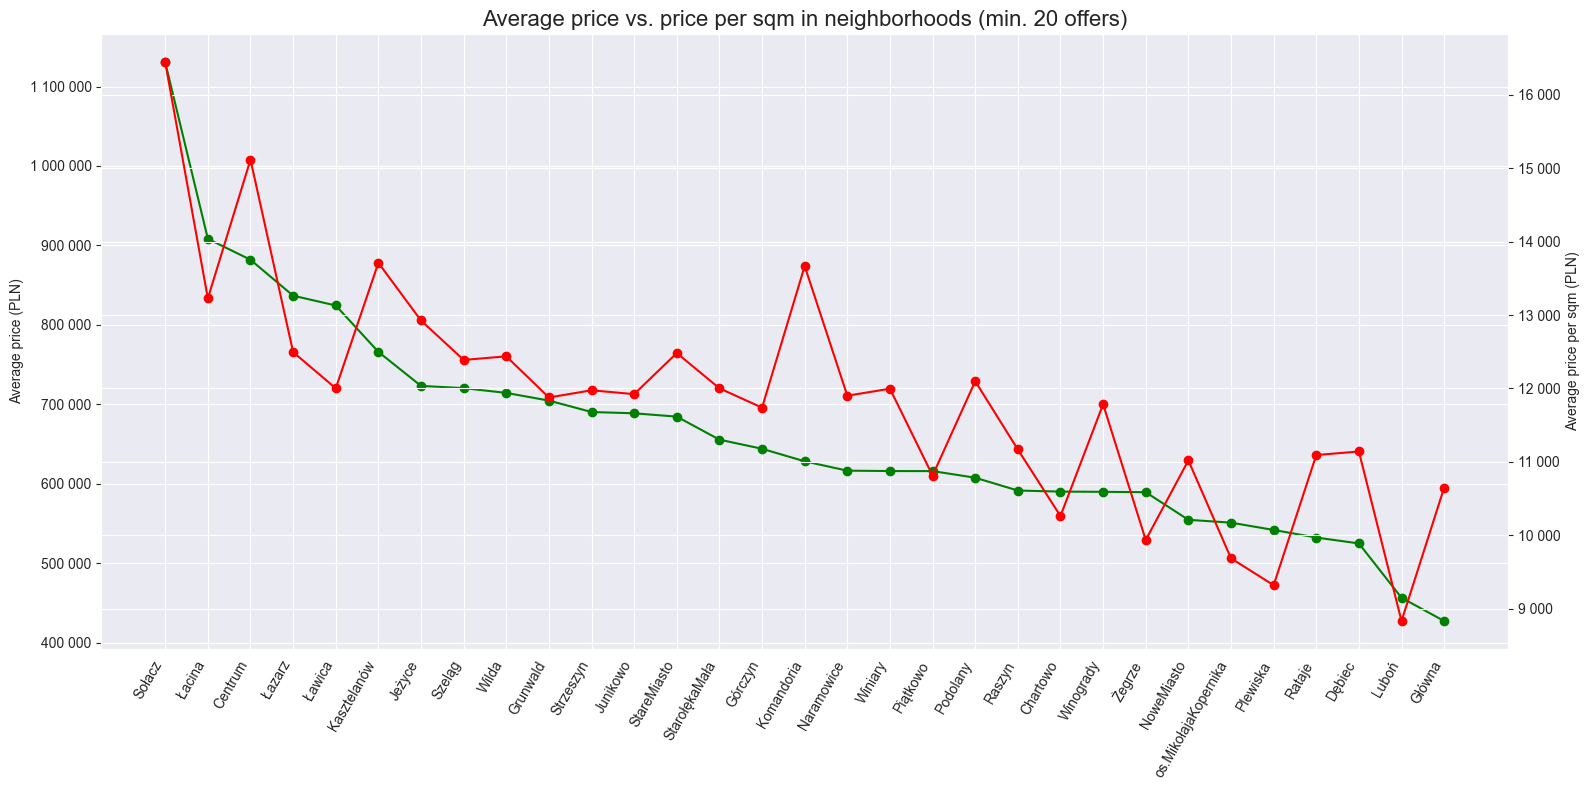

In [120]:
df_sorted = df_filtered.sort_values(by='avg_price', ascending=False)

# X axis
districts = df_sorted['district_1']
x = range(len(districts))

# graph with two Y axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Green graph: avg_price (left Y axis)
ax1.plot(x, df_sorted['avg_price'], color='green', marker='o', label='Average price')
ax1.set_ylabel('Average price (PLN)')
ax1.tick_params(axis='y')
ax1.set_xticks(x)
ax1.set_xticklabels(districts, rotation=60, ha='right')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))) # Y-axis formatting (left)

# Red Y axis: avg_price_per_sqm
ax2 = ax1.twinx()
ax2.plot(x, df_sorted['avg_price_per_sqm'], color='red', marker='o', label='Price per sqm')
ax2.set_ylabel('Average price per sqm (PLN)')
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' '))) # Y-axis formatting (right)

plt.title('Average price vs. price per sqm in neighborhoods (min. 20 offers)', fontsize=16)
plt.tight_layout()
plt.show()

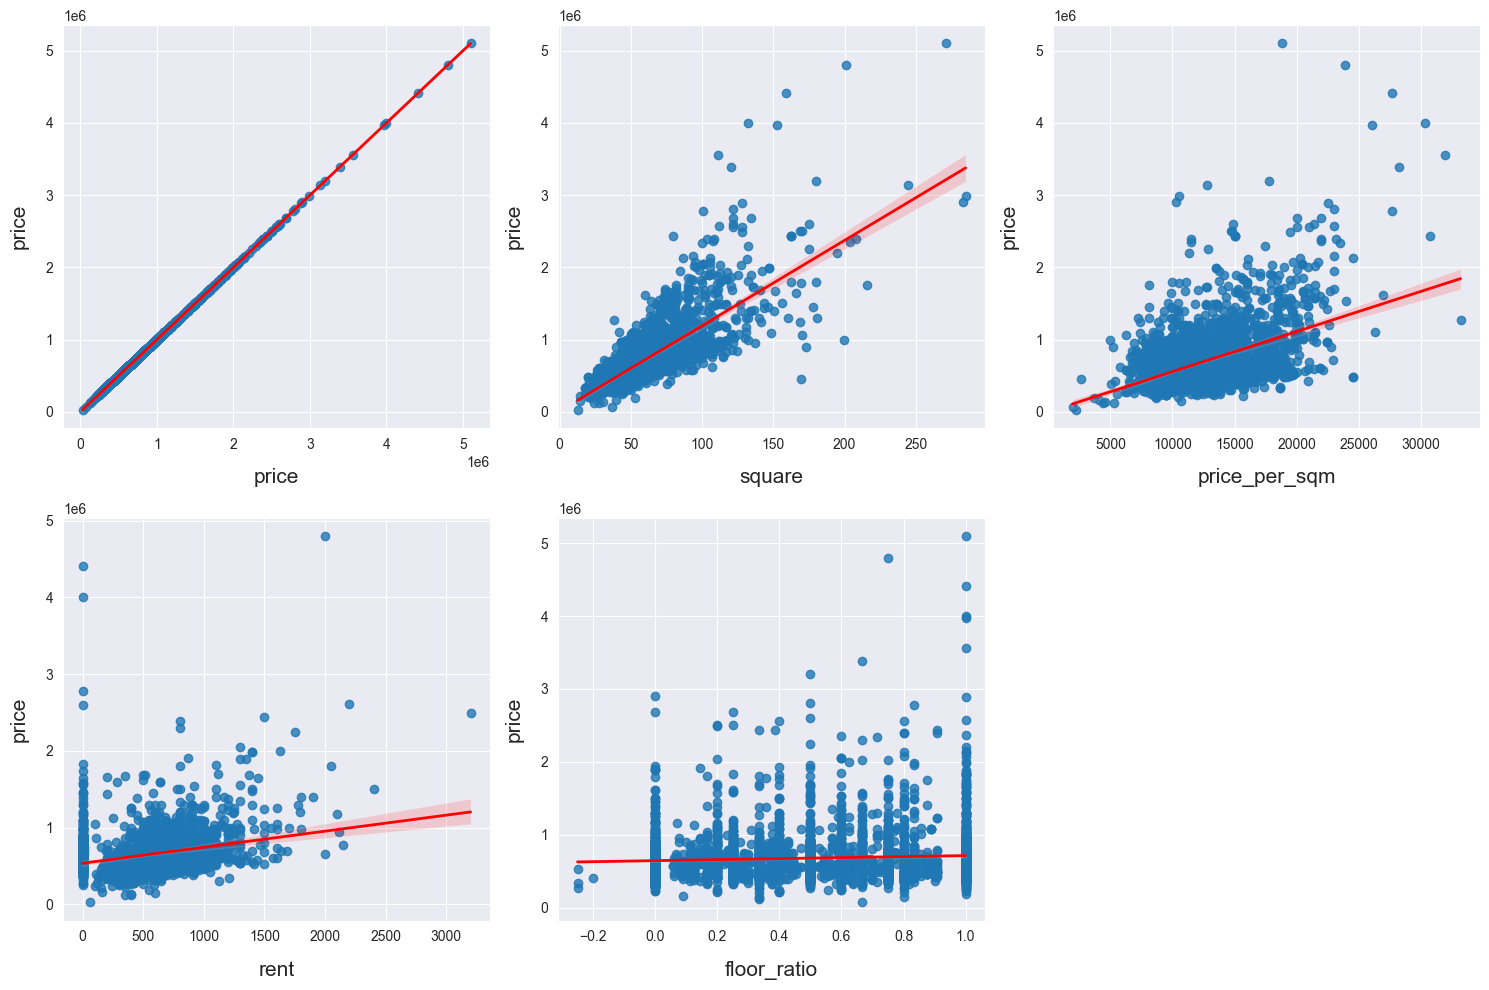

In [121]:
reg_viz(df, num_features, 'price')

The removed conspicuous misplaced values have made the regplot's look much better and we can draw better conclusions from them, such as: 

`square` vs `price`
- Clear **positive linear relationship**.
- Higher square footage strongly correlates with higher property prices.

`price_per_sqm` vs `price`
- Weak to moderate **positive trend**, but lots of spread and outliers.
- This feature is derived from `price` itself (`price / square`) so including it causes **data leakage**

`floor_ratio` vs `price`
- No clear linear relationship. Data is heavily clustered with some vertical streaks.
- Regression line is nearly flat.
- Might be useful in nonlinear models, but low predictive power on its own.

`rent` vs `price`
- Weak **positive relationship**.
- Some clusters with high variance, but trend line still slopes upward.



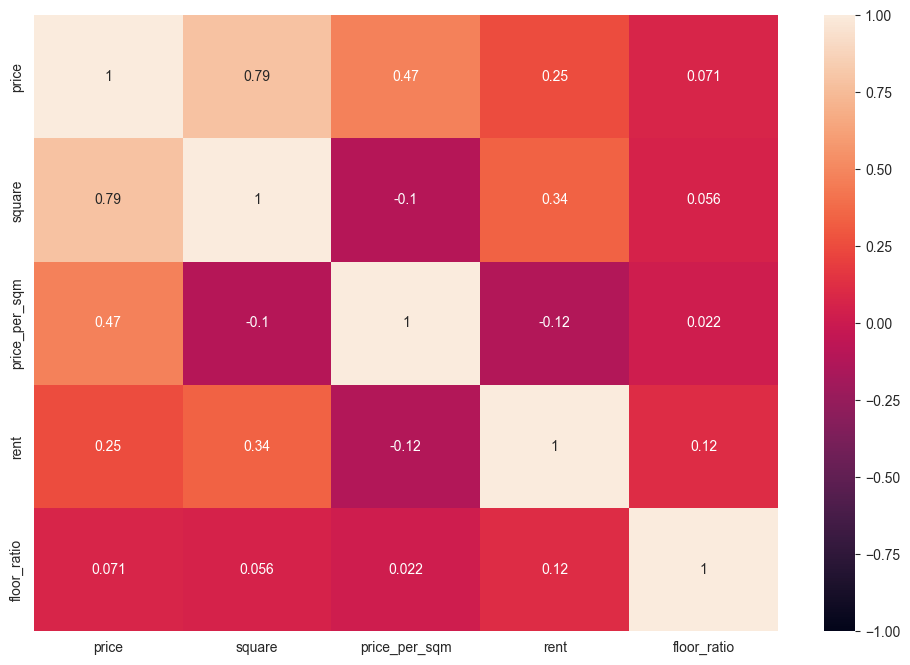

In [122]:
corr = df[num_features].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True ,vmin= -1, vmax= 1)
plt.show()

### Correlation Heatmap Analysis

**Target Variable: `price`**

This heatmap shows the Pearson correlation coefficients between the target variable `price` and other numerical features. Here's a breakdown:

**Strong Correlations**

- **`square` (0.79)**  
  Strong positive correlation. Larger properties tend to have higher prices.  
- **`price_per_sqm` (0.47)**  
  Moderate correlation, **but derived from the target**: `price / square`.  
  **Should be excluded** from the model to avoid data leakage.

**Moderate or Weak Correlations**

- **`rent` (0.25)**  
  Weak-to-moderate correlation. Rent prices can reflect market value.  
- **`floor_ratio` (0.07)**  
  Very weak correlation with price. Possibly useful in nonlinear models.  

**Negative or Irrelevant Correlations**
- **`price_per_sqm` vs `square` (-0.10)**  
  Negative relationship expected (larger properties usually have a lower price per m²).
- Other correlations are close to 0 → not meaningful for prediction in linear models.

In [123]:
df.drop(columns=['price_per_sqm'], inplace=True)

## Missing values

,Total,Percent
rent,2044,46.12
building_year,1119,25.25
heating,859,19.38
ownership,679,15.32
bld_condition,591,13.33
building_type,573,12.93
floor_ratio,336,7.58
num_floors,332,7.49
property_floor,63,1.42


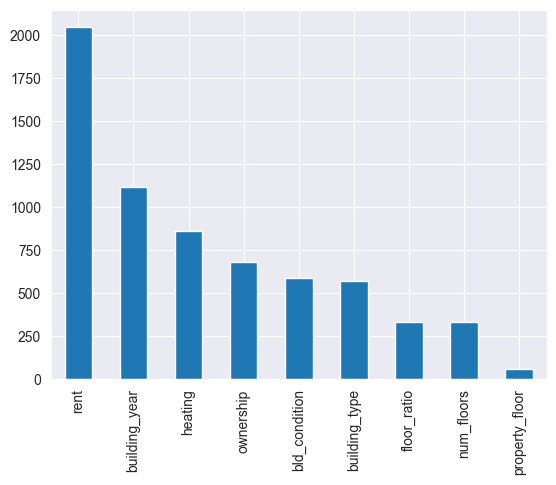

In [124]:
missing_data_bar_plot(df)
missing_values(df)

### Strategy for filling in missing data 

1. floor_ratio, num_floors, property_floor will fill by median values, since their deficiencies account for <10% of all data
2. building_year, heating, ownership, bld_condition as categorical variables in missing data will get 'unknown'
3. The variable 'rent' will be completed with a predictive model 


(4432, 19)